In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import os
import copy 
import random
import json

sys.path.insert(1, os.path.realpath(os.path.pardir))

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


from node2vec2rank.post_utils import discounted_cumulative_gain, normalized_discounted_cumulative_gain
from node2vec2rank.pre_utils import network_transform

from node2vec2rank.model import n2v2r
from scipy.sparse import csc_matrix

from sklearn import preprocessing

from scipy import stats

import spectral_embedding as se         

In [2]:
def generate_two_DSBM_graphs_fixed_four_original(num_nodes, multiplicity = 1):
    num_com = 4

    pi = np.repeat(1/num_com, num_com)

    Bs = np.array([[[0.08, 0.02, 0.18, 0.10],
                    [0.02, 0.20, 0.04, 0.10],
                    [0.18, 0.04, 0.02, 0.02],
                    [0.10, 0.10, 0.02, 0.06]],
                [[0.16, 0.16, 0.04, 0.10],
                    [0.16, 0.16, 0.04, 0.10],
                    [0.04, 0.04, 0.09, 0.02],
                    [0.10, 0.10, 0.02, 0.06]]])
    

    list_of_pairs_of_graphs = []
    list_of_assignments = []

    for i in range(multiplicity):

        As, Z = se.generate_SBM_dynamic(num_nodes, Bs, pi)

        colours = np.array(list(mpl.colors.TABLEAU_COLORS.keys())[0:num_com])
        Zcol = colours[Z]
        
        list_of_pairs_of_graphs.append(As)

        le = preprocessing.LabelEncoder()
        assignments = le.fit_transform(Zcol)
        list_of_assignments.append(assignments)
    
    return list_of_pairs_of_graphs, Bs[0], Bs[1], list_of_assignments

def generate_two_DSBM_graphs_random_changes(num_nodes, num_com, max_comm_prob=0.5, multiplicity_model = 1, multiplicity_samples=1):

    list_of_pairs_of_graphs = []
    list_of_assignments = []

    for _ in range(multiplicity_model):

        first_true_memb_matrix = np.random.uniform(0.01, max_comm_prob,(num_com,num_com))
        second_true_memb_matrix = np.random.uniform(0.01, max_comm_prob,(num_com,num_com))

        stacked_true_memb_matrix = np.stack((first_true_memb_matrix, second_true_memb_matrix))

        pi = np.repeat(1/num_com, num_com)

        for _ in range(multiplicity_samples):

            As, Z = se.generate_SBM_dynamic(num_nodes, stacked_true_memb_matrix, pi)

            colours = np.array(list(mpl.colors.TABLEAU_COLORS.keys())[0:num_com])
            Zcol = colours[Z]
            
            list_of_pairs_of_graphs.append(As)

            le = preprocessing.LabelEncoder()
            assignments = le.fit_transform(Zcol)
            list_of_assignments.append(assignments)
    
    return list_of_pairs_of_graphs, stacked_true_memb_matrix[0], stacked_true_memb_matrix[1], list_of_assignments


"""
Given a ranking (node integer IDs) and the true community membership matrices, it outputs the total and per group ndcg
"""
def evaluate_DBSM_ranking(first_true_memb_matrix, second_true_memb_matrix, ranking, assignments):
    ranking = np.int16(ranking)
    assignments = np.int16(assignments) + 1
    num_communities = first_true_memb_matrix.shape[1]

    #contains the community of each node in the ranking
    ranking_com_mapped = assignments[ranking].copy()

    #rank the communities according to how much they changed
    Ds = np.linalg.norm(np.abs(first_true_memb_matrix-second_true_memb_matrix), axis=1)
    sort_comm_difs = np.flip(np.argsort(Ds)) + 1

    rel_dict  = {}
    for i in range(num_communities):
        rel_dict[sort_comm_difs[i]] = num_communities - i

    total_ranking_relevance = []
    for i in range(ranking_com_mapped.size):
        relevance_of_node = rel_dict[ranking_com_mapped[i]]
        total_ranking_relevance.append(relevance_of_node)

    ## get the ndcg for the entire ranking (non binary relevance)
    total_ranking_relevance = np.int16(total_ranking_relevance)
    total_score= normalized_discounted_cumulative_gain(total_ranking_relevance, binary_relevance=False) 


    scores = []
    scores.append(total_score)
    ##get the ndcg per community (binary relevance)
    prev_com_num_nodes = 0
    for i in range(num_communities):
        nodes_in_com = np.where(assignments==sort_comm_difs[i])[0]
        num_nodes_in_com = nodes_in_com.shape[0]
        com_relevance = num_communities-i

        group_relevance = total_ranking_relevance[prev_com_num_nodes:(prev_com_num_nodes+num_nodes_in_com-1)].copy()

        prev_com_num_nodes = prev_com_num_nodes + num_nodes_in_com
        group_relevance[group_relevance!=com_relevance] = 0
        group_relevance[group_relevance!=0] = 1

        group_score= normalized_discounted_cumulative_gain(group_relevance, binary_relevance=True)
        scores.append(group_score)

    return scores, total_ranking_relevance


Running n2v2r with dimensions [2, 4, 8, 16] and distance metrics ['euclidean', 'cosine', 'chebyshev'] ...
n2v2r computed 1(1.0) rankings in 0.37 seconds

Rank aggregation with Borda ...
	Finished aggregation in 2.58 seconds

Running n2v2r with dimensions [2, 4, 8, 16] and distance metrics ['euclidean', 'cosine', 'chebyshev'] ...
n2v2r computed 1(1.0) rankings in 0.37 seconds

Rank aggregation with Borda ...
	Finished aggregation in 0.65 seconds

Running n2v2r with dimensions [2, 4, 8, 16] and distance metrics ['euclidean', 'cosine', 'chebyshev'] ...
n2v2r computed 1(1.0) rankings in 0.42 seconds

Rank aggregation with Borda ...
	Finished aggregation in 0.64 seconds

Running n2v2r with dimensions [2, 4, 8, 16] and distance metrics ['euclidean', 'cosine', 'chebyshev'] ...
n2v2r computed 1(1.0) rankings in 0.38 seconds

Rank aggregation with Borda ...
	Finished aggregation in 0.64 seconds

Running n2v2r with dimensions [2, 4, 8, 16] and distance metrics ['euclidean', 'cosine', 'chebyshev

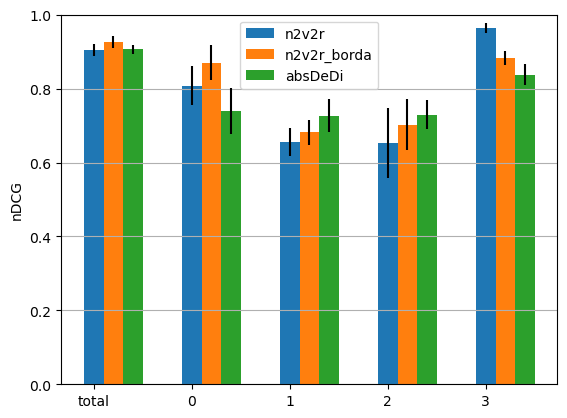

In [3]:
from node2vec2rank.visualization_utils import dim_reduction, plot_embeddings

num_nodes = 1000
num_com = 4
multiplicity_samples = 100

list_of_pairs_of_graphs, first_true_memb_matrix, second_true_memb_matrix, list_of_assignments = generate_two_DSBM_graphs_fixed_four_original(num_nodes=num_nodes, multiplicity=multiplicity_samples)

# list_of_pairs_of_graphs_pd = [pd.DataFrame(x, index =)]

all_absDeDi_scores = []
all_n2v2r_scores = []
all_n2v2r_borda_scores = []

#read the config file and create output file it doesn't exist
config = json.load(open('../configs/config_DBSM.json', 'r'))

config = {param: value for section, params in config.items()
          for param, value in params.items()}

node_names = dict(zip(np.arange(num_nodes), np.arange(num_nodes)))

for i in range(len(list_of_pairs_of_graphs)):
    random_graphs = list_of_pairs_of_graphs[i]
    assignments = list_of_assignments[i]


    # graphs.append(csc_matrix(random_graphs[0]))
    # graphs.append(csc_matrix(random_graphs[1]))

    model = n2v2r(graphs=random_graphs, config=config, node_names=node_names)
    rankings = model.fit_transform_rank()[0]
    rankings_s = rankings.iloc[:,0]
    
    n2v2r_ranked_nodes = rankings_s.sort_values(ascending = False, inplace=False).index.to_list()
    n2v2r_borda_ranking = model.aggregate_transform()[0].index.to_list()

    degs_one = np.sum(random_graphs[0], axis = 0)
    degs_two = np.sum(random_graphs[1], axis = 0)
    absDeDi = np.abs(degs_two - degs_one)
    absDeDi_ranked_nodes = np.flip(np.argsort(absDeDi))
  
    n2v2r_scores, _ = evaluate_DBSM_ranking(first_true_memb_matrix, second_true_memb_matrix, n2v2r_ranked_nodes, assignments)  
    n2v2r_borda_scores, _ = evaluate_DBSM_ranking(first_true_memb_matrix, second_true_memb_matrix, n2v2r_borda_ranking, assignments)                                                                                 
    absDeDi_scores, _ = evaluate_DBSM_ranking(first_true_memb_matrix, second_true_memb_matrix, absDeDi_ranked_nodes, assignments)

    all_absDeDi_scores.append(absDeDi_scores)
    all_n2v2r_scores.append(n2v2r_scores)
    all_n2v2r_borda_scores.append(n2v2r_borda_scores)

all_n2v2r_scores_np = np.asarray(all_n2v2r_scores)
all_n2v2r_borda_scores_np = np.asarray(all_n2v2r_borda_scores)
all_absDeDi_scores_np = np.asarray(all_absDeDi_scores)

mean_n2v2r_scores = np.mean(all_n2v2r_scores_np, axis = 0)
mean_n2v2r_borda_scores = np.mean(all_n2v2r_borda_scores_np, axis = 0)
mean_absDeDi_scores = np.mean(all_absDeDi_scores_np, axis = 0)

std_n2v2r_scores = np.std(all_n2v2r_scores_np, axis = 0)
std_n2v2r_borda_scores = np.std(all_n2v2r_borda_scores_np, axis = 0)
std_absDeDi_scores = np.std(all_absDeDi_scores_np, axis = 0)

comms_string = [ str(i) for i in range(num_com)]
algo = ['total', *comms_string]

x = np.arange(num_com+1)
y1 = mean_n2v2r_scores
y2 = mean_n2v2r_borda_scores
y3 = mean_absDeDi_scores
width = 0.20

fig, ax = plt.subplots()

x_pos = np.arange(len(algo))
ax.set_ylabel('nDCG')
ax.set_xticks(x_pos)
ax.set_xticklabels(algo)
# ax.set_title('Fixed 4 uniform comms, 1000 nodes, 20 models, 5 reps')
ax.yaxis.grid(True)
ax.set_ylim(0,1)

# plot data in grouped manner of bar type
plt.bar(x, y1, width, yerr=std_n2v2r_scores)
plt.bar(x+0.2, y2, width, yerr= std_n2v2r_borda_scores)
plt.bar(x+0.4, y3, width, yerr= std_absDeDi_scores)


plt.legend(["n2v2r", "n2v2r_borda", "absDeDi"])



Running n2v2r with dimensions [2, 4, 8, 16] and distance metrics ['euclidean', 'cosine', 'chebyshev'] ...
n2v2r computed 1(1.0) rankings in 0.54 seconds

Rank aggregation with Borda ...
	Finished aggregation in 0.04 seconds

Running n2v2r with dimensions [2, 4, 8, 16] and distance metrics ['euclidean', 'cosine', 'chebyshev'] ...
n2v2r computed 1(1.0) rankings in 0.55 seconds

Rank aggregation with Borda ...
	Finished aggregation in 0.04 seconds

Running n2v2r with dimensions [2, 4, 8, 16] and distance metrics ['euclidean', 'cosine', 'chebyshev'] ...
n2v2r computed 1(1.0) rankings in 2.27 seconds

Rank aggregation with Borda ...
	Finished aggregation in 0.09 seconds

Running n2v2r with dimensions [2, 4, 8, 16] and distance metrics ['euclidean', 'cosine', 'chebyshev'] ...
n2v2r computed 1(1.0) rankings in 0.6 seconds

Rank aggregation with Borda ...
	Finished aggregation in 0.04 seconds

Running n2v2r with dimensions [2, 4, 8, 16] and distance metrics ['euclidean', 'cosine', 'chebyshev'

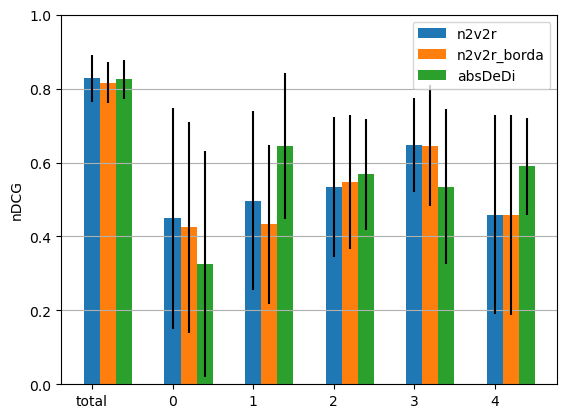

In [6]:
from node2vec2rank.visualization_utils import dim_reduction, plot_embeddings

num_nodes = 1000
num_com = 5
multiplicity_model = 10
multiplicity_samples = 10
max_comm_prob = 0.5

list_of_pairs_of_graphs, first_true_memb_matrix, second_true_memb_matrix, list_of_assignments = generate_two_DSBM_graphs_random_changes(num_nodes=num_nodes, num_com=num_com, max_comm_prob=max_comm_prob,multiplicity_model=multiplicity_model, multiplicity_samples=multiplicity_samples)

all_absDeDi_scores = []
all_n2v2r_scores = []
all_n2v2r_borda_scores = []

#read the config file and create output file it doesn't exist
config = json.load(open('../configs/config_DBSM.json', 'r'))

config = {param: value for section, params in config.items()
          for param, value in params.items()}

node_names = dict(zip(np.arange(num_nodes), np.arange(num_nodes)))

for i in range(len(list_of_pairs_of_graphs)):
    random_graphs = list_of_pairs_of_graphs[i]
    assignments = list_of_assignments[i]


    model = n2v2r(graphs=random_graphs, config=config, node_names=node_names)
    rankings = model.fit_transform_rank()[0]
    rankings_s = rankings.iloc[:,0]
    
    n2v2r_ranked_nodes = rankings_s.sort_values(ascending = False, inplace=False).index.to_list()
    n2v2r_borda_ranking = model.aggregate_transform()[0].index.to_list()

    degs_one = np.sum(random_graphs[0], axis = 0)
    degs_two = np.sum(random_graphs[1], axis = 0)
    absDeDi = np.abs(degs_two - degs_one)
    absDeDi_ranked_nodes = np.flip(np.argsort(absDeDi))
  
    n2v2r_scores, _ = evaluate_DBSM_ranking(first_true_memb_matrix, second_true_memb_matrix, n2v2r_ranked_nodes, assignments)  
    n2v2r_borda_scores, _ = evaluate_DBSM_ranking(first_true_memb_matrix, second_true_memb_matrix, n2v2r_borda_ranking, assignments)                                                                                 
    absDeDi_scores, _ = evaluate_DBSM_ranking(first_true_memb_matrix, second_true_memb_matrix, absDeDi_ranked_nodes, assignments)

    all_absDeDi_scores.append(absDeDi_scores)
    all_n2v2r_scores.append(n2v2r_scores)
    all_n2v2r_borda_scores.append(n2v2r_borda_scores)

all_n2v2r_scores_np = np.asarray(all_n2v2r_scores)
all_n2v2r_borda_scores_np = np.asarray(all_n2v2r_borda_scores)
all_absDeDi_scores_np = np.asarray(all_absDeDi_scores)

mean_n2v2r_scores = np.mean(all_n2v2r_scores_np, axis = 0)
mean_n2v2r_borda_scores = np.mean(all_n2v2r_borda_scores_np, axis = 0)
mean_absDeDi_scores = np.mean(all_absDeDi_scores_np, axis = 0)

std_n2v2r_scores = np.std(all_n2v2r_scores_np, axis = 0)
std_n2v2r_borda_scores = np.std(all_n2v2r_borda_scores_np, axis = 0)
std_absDeDi_scores = np.std(all_absDeDi_scores_np, axis = 0)

comms_string = [ str(i) for i in range(num_com)]
algo = ['total', *comms_string]

x = np.arange(num_com+1)
y1 = mean_n2v2r_scores
y2 = mean_n2v2r_borda_scores
y3 = mean_absDeDi_scores
width = 0.20

fig, ax = plt.subplots()

x_pos = np.arange(len(algo))
ax.set_ylabel('nDCG')
ax.set_xticks(x_pos)
ax.set_xticklabels(algo)
# ax.set_title('Fixed 4 uniform comms, 1000 nodes, 20 models, 5 reps')
ax.yaxis.grid(True)
ax.set_ylim(0,1)

# plot data in grouped manner of bar type
plt.bar(x, y1, width, yerr=std_n2v2r_scores)
plt.bar(x+0.2, y2, width, yerr= std_n2v2r_borda_scores)
plt.bar(x+0.4, y3, width, yerr= std_absDeDi_scores)


plt.legend(["n2v2r", "n2v2r_borda", "absDeDi"])